<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SA on Contacts Configs

#### Experiment Parameters:
- Parameters to be tested: home_sar(0.01 - 0.6), work_sar(0.01-0.3), other_sar(0.01-0.3)
- Random Seed = 42
- Run tti stimulator = 50 times
- experiment design loop (if using) = 5 times

## Running a Simulation

In [1]:
from emukit_new.core import DiscreteParameter, ContinuousParameter, ParameterSpace
from emukit_new.core.initial_designs import RandomDesign
from emukit_new.model_wrappers import GPyModelWrapper
from emukit_new.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit_new.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSecondOrderSensitivity

In [2]:
# !git clone https://github.com/rs-delve/tti-explorer.git
# %cd tti-explorer
# %pip install -q .
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

# %pip install pyDOE
# %pip install emukit
# %pip install gpy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')

from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
from GPy.models import GPRegression
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai
import pandas as pd

We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

In [3]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("../../data", "bbc-pandemic")
over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

First get the configurations:

In [4]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

In [6]:
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [7]:
rng = np.random.RandomState(42)

Make contact simulator:

In [8]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [9]:
tti_model = TTIFlowModel(rng, **strategy_config)

Define function that update desired contacts configs

In [11]:
def update_contacts_config(home_sar, work_sar, other_sar):
    contacts_config['home_sar'] = home_sar
    contacts_config['work_sar'] = work_sar
    contacts_config['other_sar'] = other_sar
    return contacts_config

Generate cases, contacts and run simulation:

In [12]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

def run_tti_sim(configs):
    to_return=[]
    for vals in configs:
        contacts_config = update_contacts_config(vals[0],vals[1],vals[2])
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)


In [13]:
max_home_infectivity = 0.6

variable_domain1 = [0.01, max_home_infectivity] 
variable_domain2 = [0.01, (1-max_home_infectivity)/2] 
variable_domain3 = [0.01, (1-max_home_infectivity)/2]


initial_samples = 50 # number of random runs to perform before starting experimental design 
space = ParameterSpace([ContinuousParameter('home_sar', *variable_domain1),
                        ContinuousParameter('work_sar', *variable_domain2),
                        ContinuousParameter('other_sar', *variable_domain3)]) # init param space for experimental design
design = RandomDesign(space)
x = design.get_samples(initial_samples) # get n random combinations of initialisations
y = run_tti_sim(x) # obtain corresponding effective_rs

In [14]:
# Fitting emulator to data, x: (param to be tested), y: effective_r
Num_of_param = 3
kern_eq = GPy.kern.RBF(input_dim=Num_of_param, ARD = True) +  GPy.kern.White(input_dim=Num_of_param, variance=1)
kern_bias = GPy.kern.Bias(input_dim=Num_of_param)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
# model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)

Optimization restart 1/1, f = -7.383584579915173


GP_regression.,value,constraints,priors
sum.rbf.variance,92.13337874209424,+ve,
sum.rbf.lengthscale,"(3,)",+ve,
sum.white.variance,0.011303241658483357,+ve,
sum.bias.variance,16.237953576670222,+ve,
Gaussian_noise.variance,0.011303241658483357,+ve,


----
## SA without Experiment Design Loop
- SA Lib -> Sobol Monte Carlo (100000 times)
- Emukit -> Sobol Monte Carlo (100000 times)
- SA Lib -> Fast (100000 times)

In [15]:
#SALib Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol

param = ['Home','Work','Others']
no_of_samples = 100000
problem = {
'num_vars': 3,
'names': param,
'bounds': [
            variable_domain1, 
            variable_domain2,
            variable_domain3]
}

xt = saltelli.sample(problem, no_of_samples)
Y,_= model_gpy.predict(xt)
Y = np.squeeze(Y)
Si = sobol.analyze(problem, Y)

#Emukit Sobol
senstivity = MonteCarloSecondOrderSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, secondary_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = no_of_samples)


#SALib Fast
from SALib.analyze import fast
from SALib.sample import fast_sampler

xt = fast_sampler.sample(problem, no_of_samples)
Y,_= model_gpy.predict(xt)
Y = np.squeeze(Y)
Si_fast = fast.analyze(problem, Y, print_to_console=False)

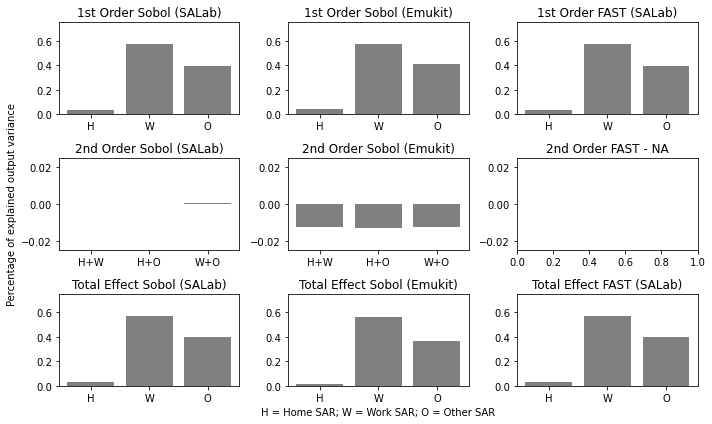

In [23]:
param = ['H','W','O']
param2 = []

first_lim = [0, 0.75]
second_lim = [-0.025, 0.025]
total_lim = [0, 0.75]

fig, ax = plt.subplots(3, 3, figsize=plot.big_wide_figsize)


ax[0][0].set_title("1st Order Sobol (SALab)")
for index,val in enumerate(Si['S1']):
    ax[0][0].bar(param[index],val, color = 'grey')
ax[0][0].set_ylim(first_lim)

ax[1][0].set_title("2nd Order Sobol (SALab)")
for i in range(len(param)):
    for j in range(len(param)):
        val =  Si['S2'][i][j]
        if val > -0.5:
            name = param[i] + '+'+ param[j]
            ax[1][0].bar(name, Si['S2'][i][j], color = 'grey')
            param2.append(name)
ax[1][0].set_ylim(second_lim)

ax[2][0].set_title("Total Effect Sobol (SALab)")
for index,val in enumerate(Si['ST']):
    ax[2][0].bar(param[index],val, color = 'grey')
ax[2][0].set_ylim(total_lim)
    
ax[0][1].set_title("1st Order Sobol (Emukit)")
for index, ivar in enumerate(main_effects_gp):
    ax[0][1].bar(param[index], main_effects_gp[ivar][0], color = 'grey')
ax[0][1].set_ylim(first_lim)


ax[1][1].set_title("2nd Order Sobol (Emukit)")
for index, ivar in enumerate(secondary_effects_gp):
    ax[1][1].bar(param2[index], secondary_effects_gp[ivar][0], color = 'grey')
ax[1][1].set_ylim(second_lim)

 
ax[2][1].set_title("Total Effect Sobol (Emukit)")
for index, ivar in enumerate(total_effects_gp):
    ax[2][1].bar(param[index], total_effects_gp[ivar][0], color = 'grey')
ax[2][1].set_ylim(total_lim)
    
ax[0][2].set_title("1st Order FAST (SALab)")
for index,val in enumerate(Si_fast['S1']):
    ax[0][2].bar(param[index],val, color = 'grey')
ax[0][2].set_ylim(first_lim)

ax[1][2].set_title("2nd Order FAST - NA")
ax[1][2].set_ylim(second_lim)

ax[2][2].set_title("Total Effect FAST (SALab)")
for index,val in enumerate(Si_fast['ST']):
    ax[2][2].bar(param[index],val, color = 'grey')
ax[2][2].set_ylim(total_lim)
    
# ax[0][1].set_title('Sensitivity Analysis on Policy Configurations Without Experimental Design Loop')
ax[1][0].set_ylabel('Percentage of explained output variance')
ax[2][1].set_xlabel('H = Home SAR; W = Work SAR; O = Other SAR')

plt.tight_layout()
# plt.show()
plt.savefig('./plots/SA-Contacts-NoExp.jpg')

## SA with Experiment Design Loop

In [25]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 5
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, num_of_loops)

Optimization restart 1/1, f = -7.383584579952526



Optimization restart 1/1, f = -7.856936810673108



Optimization restart 1/1, f = -7.65940079724113



Optimization restart 1/1, f = -8.372852879480668



Optimization restart 1/1, f = -9.06354928163935



Optimization restart 1/1, f = -9.854151594058656


In [26]:
display(model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,160.71795110758868,+ve,
sum.rbf.lengthscale,"(3,)",+ve,
sum.white.variance,0.011217952150028153,+ve,
sum.bias.variance,0.0008166220774729389,+ve,
Gaussian_noise.variance,0.011217952150028153,+ve,


In [32]:
#SALib Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol
import time 

no_of_samples = 100000
t1 = time.time()
problem = {
'num_vars': 3,
'names': param,
'bounds': [
            variable_domain1, 
            variable_domain2,
            variable_domain3]
}


xt = saltelli.sample(problem, no_of_samples)
Y,_= model_gpy.predict(xt)
Y = np.squeeze(Y)
Si_e = sobol.analyze(problem, Y)
t2 = time.time()
print('SA Lib Sobol', t2 - t1)

#Emukit Sobol
t3 = time.time()
senstivity = MonteCarloSecondOrderSensitivity(model = model_emukit, input_domain = space)
main_effects_gp_e, secondary_effects_gp_e, total_effects_gp_e, _e = senstivity.compute_effects(num_monte_carlo_points = no_of_samples)
t4 = time.time()
print('Emukit Sobol', t4 - t3)

#SALib Fast
t5 = time.time()
from SALib.analyze import fast
from SALib.sample import fast_sampler

xt = fast_sampler.sample(problem, no_of_samples)
Y,_= model_gpy.predict(xt)
Y = np.squeeze(Y)
Si_fast_e = fast.analyze(problem, Y, print_to_console=False)
t6 = time.time()
print('SA Lib FAST', t6 - t5)

SA Lib Sobol 7.228198289871216
Emukit Sobol 2.156318426132202
SA Lib FAST 0.7276594638824463


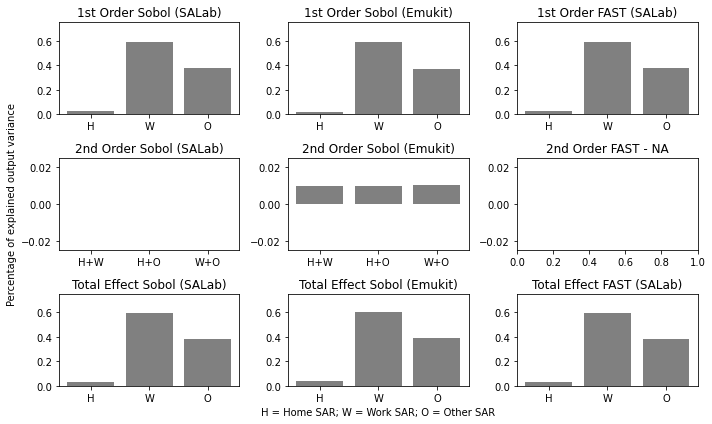

In [30]:
param = ['H','W','O']
param2 = []

first_lim = [0, 0.75]
second_lim = [-0.025, 0.025]
total_lim = [0, 0.75]

fig, ax = plt.subplots(3, 3, figsize=plot.big_wide_figsize)


ax[0][0].set_title("1st Order Sobol (SALab)")
for index,val in enumerate(Si_e['S1']):
    ax[0][0].bar(param[index],val, color = 'grey')
ax[0][0].set_ylim(first_lim)

ax[1][0].set_title("2nd Order Sobol (SALab)")
for i in range(len(param)):
    for j in range(len(param)):
        val =  Si_e['S2'][i][j]
        if val > -0.5:
            name = param[i] + '+'+ param[j]
            ax[1][0].bar(name, Si_e['S2'][i][j], color = 'grey')
            param2.append(name)
ax[1][0].set_ylim(second_lim)

ax[2][0].set_title("Total Effect Sobol (SALab)")
for index,val in enumerate(Si_e['ST']):
    ax[2][0].bar(param[index],val, color = 'grey')
ax[2][0].set_ylim(total_lim)
    
ax[0][1].set_title("1st Order Sobol (Emukit)")
for index, ivar in enumerate(main_effects_gp_e):
    ax[0][1].bar(param[index], main_effects_gp_e[ivar][0], color = 'grey')
ax[0][1].set_ylim(first_lim)


ax[1][1].set_title("2nd Order Sobol (Emukit)")
for index, ivar in enumerate(secondary_effects_gp_e):
    ax[1][1].bar(param2[index], secondary_effects_gp_e[ivar][0], color = 'grey')
ax[1][1].set_ylim(second_lim)

 
ax[2][1].set_title("Total Effect Sobol (Emukit)")
for index, ivar in enumerate(total_effects_gp_e):
    ax[2][1].bar(param[index], total_effects_gp_e[ivar][0], color = 'grey')
ax[2][1].set_ylim(total_lim)
    
ax[0][2].set_title("1st Order FAST (SALab)")
for index,val in enumerate(Si_fast_e['S1']):
    ax[0][2].bar(param[index],val, color = 'grey')
ax[0][2].set_ylim(first_lim)

ax[1][2].set_title("2nd Order FAST - NA")
ax[1][2].set_ylim(second_lim)

ax[2][2].set_title("Total Effect FAST (SALab)")
for index,val in enumerate(Si_fast_e['ST']):
    ax[2][2].bar(param[index],val, color = 'grey')
ax[2][2].set_ylim(total_lim)
    
ax[1][0].set_ylabel('Percentage of explained output variance')
ax[2][1].set_xlabel('H = Home SAR; W = Work SAR; O = Other SAR')

plt.tight_layout()
# plt.show()
plt.savefig('./plots/SA-Contacts-Exp.jpg')

In [33]:
raw_data_path = './plots/raw_data/Contacts_noExp/'
df = pd.DataFrame([Si])
df.to_csv(raw_data_path + 'Si.csv', index=False)
df = pd.DataFrame([Si_fast])
df.to_csv(raw_data_path + 'Si_fast.csv', index=False)
df = pd.DataFrame([main_effects_gp])
df.to_csv(raw_data_path + 'main_effects_gp.csv', index=False)
df = pd.DataFrame([secondary_effects_gp])
df.to_csv(raw_data_path + 'secondary_effects_gp.csv', index=False)
df = pd.DataFrame([total_effects_gp])
df.to_csv(raw_data_path + 'total_effects_gp.csv', index=False)
np.savetxt(raw_data_path + 'S2.csv', Si['S2'], delimiter=',')

raw_data_path = './plots/raw_data/Contacts_withExp/'
df = pd.DataFrame([Si_e])
df.to_csv(raw_data_path + 'Si.csv', index=False)
df = pd.DataFrame([Si_fast_e])
df.to_csv(raw_data_path + 'Si_fast.csv', index=False)
df = pd.DataFrame([main_effects_gp_e])
df.to_csv(raw_data_path + 'main_effects_gp.csv', index=False)
df = pd.DataFrame([secondary_effects_gp_e])
df.to_csv(raw_data_path + 'secondary_effects_gp.csv', index=False)
df = pd.DataFrame([total_effects_gp_e])
df.to_csv(raw_data_path + 'total_effects_gp.csv', index=False)
np.savetxt(raw_data_path + 'S2.csv', Si_e['S2'], delimiter=',')